# Contrastive Learning on Spurious MNIST dataset

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

# Utils

In [3]:
from collections import defaultdict

class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [4]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Source:
            https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'> early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
def calculate_accuracy(output, target):
    "Calculates accuracy"
    output = output.data.max(dim=1,keepdim=True)[1]
    output = output == 1.0
    output = torch.flatten(output)
    target = target == 1.0
    target = torch.flatten(target)
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [6]:
def save_model(model, optimizer, epoch, save_file):
    print('\n==> Saving...')
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

In [7]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# Method

In [8]:
from torch.nn.utils import prune

class Encoder(torch.nn.Module):
    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()
        # L1 (?, 28, 28, 3) -> (?, 28, 28, 32) -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        # L2 (?, 14, 14, 32) -> (?, 14, 14, 64) -> (?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        # L3 (?, 7, 7, 64) -> (?, 7, 7, 128) -> (?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=0.2)
            )
        self._to_linear = 4 * 4 * 128

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1) # Flatten them for FC
        return x

    # magnitude pruning
    def random_prune_layer1(self, prune_prob):
        for name, module in self.layer1.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                mask = torch.rand_like(module.weight) > prune_prob
                module.weight.data *= mask

    def random_prune_layer2(self, prune_prob):
        for name, module in self.layer2.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                mask = torch.rand_like(module.weight) > prune_prob
                module.weight.data *= mask

    def random_prune_layer3(self, prune_prob):
        for name, module in self.layer3.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                mask = torch.rand_like(module.weight) > prune_prob
                module.weight.data *= mask


class LinearClassifier(torch.nn.Module):
    """Linear classifier"""
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4 * 4 * 128, 10),
            )

    def forward(self, x):
        x = self.fc(x)
        probs = torch.nn.functional.softmax(x, dim=0)
        return probs

In [9]:
class SupCon(nn.Module):
    """encoder + projection head"""
    def __init__(self, model, head='mlp', feat_dim=128):
        super(SupCon, self).__init__()

        self.dim_in = model._to_linear
        self.encoder = model

        if head == 'linear':
            self.head = nn.Linear(self.dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(self.dim_in, self.dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(self.dim_in, feat_dim)
            )
        else:
            raise NotImplementedError('Head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [10]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

# Training

In [11]:
def pretraining(epoch, model, contrastive_loader, optimizer, criterion, method='SimCLR'):
    "Contrastive pre-training over an epoch"
    metric_monitor = MetricMonitor()
    model.train()
    for batch_idx, (data,labels) in enumerate(contrastive_loader):
        # print(batch_idx)
        # print(data[0].shape)
        # print(data[1].shape)
        # print(labels.shape)
        data = torch.cat([data[0], data[1]], dim=0)
        # print(data.shape)
        if torch.cuda.is_available():
            data,labels = data.cuda(), labels.cuda()
        data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
        bsz = labels.shape[0]
        features = model(data)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if method == 'SupCon':
            loss = criterion(features, labels)
        elif method == 'SimCLR':
            loss = criterion(features)
        else:
            raise ValueError('contrastive method not supported: {}'.format(method))
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Learning Rate", optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("[Epoch: {epoch:03d}] Contrastive Pre-train | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Learning Rate']['avg']

In [12]:
def training(epoch, model, classifier, train_loader, optimizer, criterion):
    "Training over an epoch"
    metric_monitor = MetricMonitor()
    model.eval()
    classifier.train()
    for batch_idx, (data,labels) in enumerate(train_loader):
        # print(batch_idx)
        # print(data.shape)
        # print(labels.shape)
        if torch.cuda.is_available():
            data,labels = data.cuda(), labels.cuda()
        data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
        with torch.no_grad():
            features = model.encoder(data)
        output = classifier(features.float())
        loss = criterion(output, labels)
        accuracy = calculate_accuracy(output, labels)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        data.detach()
        labels.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("[Epoch: {epoch:03d}] Train      | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [13]:
def validation(epoch, model, classifier, valid_loader, criterion):
    "Validation over an epoch"
    metric_monitor = MetricMonitor()
    model.eval()
    classifier.eval()
    with torch.no_grad():
        for batch_idx, (data,labels) in enumerate(valid_loader):
            if torch.cuda.is_available():
                data,labels = data.cuda(), labels.cuda()
            data, labels = torch.autograd.Variable(data,False), torch.autograd.Variable(labels)
            features = model.encoder(data)
            output = classifier(features.float())
            loss = criterion(output,labels)
            accuracy = calculate_accuracy(output, labels)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            data.detach()
            labels.detach()
    print("[Epoch: {epoch:03d}] Validation | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

# Adding Spurious Fetures

In [14]:
import PIL
import random

def add_spurious_feature(img: PIL.Image.Image) -> PIL.Image.Image:
    img = img.convert("RGB")
    d = img.getdata()
    new_image = []
    color = random.randint(0, 3)
    for item in d:
        # change all white (also shades of whites)
        if item[0] in list(range(200, 256)):
          if color == 0:
            new_image.append((255, 0, 0)) # red
          elif color == 1:
            new_image.append((0, 255, 0)) # green
          elif color == 2:
            new_image.append((0, 0, 255)) # blue
          else:
            new_image.append((252, 255, 0)) # yellow
        else:
          new_image.append(item)
    img.putdata(new_image)
    return img

# Data

In [15]:
contrastive_transform = transforms.Compose([
  transforms.Lambda(add_spurious_feature),
  transforms.RandomHorizontalFlip(),
  transforms.RandomResizedCrop(size=28, scale=(0.2, 1.)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])
train_transform = transforms.Compose([
  transforms.Lambda(add_spurious_feature),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])
valid_transform = transforms.Compose([
  transforms.Lambda(add_spurious_feature),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])

contrastive_set = datasets.MNIST('./data', download=True, train=True, transform=TwoCropTransform(contrastive_transform))
train_set = datasets.MNIST('./data', download=True, train=True, transform=train_transform)
valid_set = datasets.MNIST('./data', download=True, train=False, transform=valid_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 82356843.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32441267.76it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21398907.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5576852.68it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [16]:
print(contrastive_set)
print(contrastive_set.classes)
print(len(contrastive_set.classes))
print(len(contrastive_set))
print(len(contrastive_set[0])) # 2 entries (2 crops of same img for a given label)
print(len(contrastive_set[0][0])) # img, label
print(len(contrastive_set[0][0][0])) # color channel
print(len(contrastive_set[0][0][0][0])) # dim
print(len(contrastive_set[0][0][0][0][0])) # dim

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <__main__.TwoCropTransform object at 0x7d3de4e61450>
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
10
60000
2
2
3
28
28


In [17]:
print(train_set)
print(train_set.classes)
print(len(train_set.classes))
print(len(train_set))
print(len(train_set[0])) # img, label
print(len(train_set[0][0])) # color channel
print(len(train_set[0][0][0])) # dim
print(len(train_set[0][0][0][0])) # dim

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
10
60000
2
3
28
28


In [18]:
print(valid_set)
print(valid_set.classes)
print(len(valid_set.classes))
print(len(valid_set))
print(len(valid_set[0])) # img, label
print(len(valid_set[0][0])) # color channel
print(len(valid_set[0][0][0])) # dim
print(len(valid_set[0][0][0][0])) # dim

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Lambda()
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
10
10000
2
3
28
28


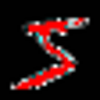

In [ ]:
import torchvision.transforms as T
T.ToPILImage()(contrastive_set[0][0][0]).resize((100,100))

# 4. Main

In [19]:
import os

def main():

    num_epochs = 50
    use_early_stopping = True
    use_scheduler = True
    head_type = 'mlp' # choose among 'mlp' and 'linear'
    save_file = os.path.join('./results/', 'model.pth')
    if not os.path.isdir('./results/'):
         os.makedirs('./results/')

    contrastive_loader = torch.utils.data.DataLoader(contrastive_set, batch_size=64, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

    # Part 1
    encoder = Encoder()
    model = SupCon(encoder, head=head_type, feat_dim=128)
    criterion = SupConLoss(temperature=0.07)
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    contrastive_loss, contrastive_lr = [], []

    for epoch in range(1, num_epochs+1):
        print('Epoch {} start'.format(epoch))
        loss, lr = pretraining(epoch, model, contrastive_loader, optimizer, criterion, method='SimCLR')
        if use_scheduler:
            scheduler.step()
        contrastive_loss.append(loss)
        contrastive_lr.append(lr)
        print('Epoch {} end'.format(epoch))

    save_model(model, optimizer, num_epochs, save_file)

    plt.plot(range(1,len(contrastive_lr)+1),contrastive_lr, color='b', label = 'learning rate')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Learning Rate'), plt.show()

    plt.plot(range(1,len(contrastive_loss)+1),contrastive_loss, color='b', label = 'loss')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()

    # Part 2
    model = SupCon(encoder, head=head_type, feat_dim=128)
    classifier = LinearClassifier()
    criterion = torch.nn.CrossEntropyLoss()

    ckpt = torch.load(save_file, map_location='cpu')
    state_dict = ckpt['model']
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    state_dict = new_state_dict
    model.load_state_dict(state_dict)

    if torch.cuda.is_available():
        model = model.cuda()
        classifier = classifier.cuda()
        criterion = criterion.cuda()

    train_losses , train_accuracies = [],[]
    valid_losses , valid_accuracies = [],[]

    if use_early_stopping:
        early_stopping = EarlyStopping(patience=30, verbose=False, delta=1e-4)

    for epoch in range(1, num_epochs+1):
        print('Epoch {} start'.format(epoch))

        train_loss, train_accuracy = training(epoch, model, classifier, train_loader, optimizer, criterion)
        valid_loss, valid_accuracy = validation(epoch, model, classifier, valid_loader, criterion)

        if use_scheduler:
            scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print('Epoch {} end'.format(epoch))

        if use_early_stopping:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print('Early stopping at epoch', epoch)
                #model.load_state_dict(torch.load('checkpoint.pt'))
                break

    plt.plot(range(1,len(train_losses)+1), train_losses, color='b', label = 'training loss')
    plt.plot(range(1,len(valid_losses)+1), valid_losses, color='r', linestyle='dashed', label = 'validation loss')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()

    plt.plot(range(1,len(train_accuracies)+1),train_accuracies, color='b', label = 'training accuracy')
    plt.plot(range(1,len(valid_accuracies)+1),valid_accuracies, color='r', linestyle='dashed', label = 'validation accuracy')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Accuracy'), plt.show()

Epoch 1 start
[Epoch: 001] Contrastive Pre-train | Loss: 2.9678 | Learning Rate: 0.0010
Epoch 1 end
Epoch 2 start
[Epoch: 002] Contrastive Pre-train | Loss: 2.0144 | Learning Rate: 0.0010
Epoch 2 end
Epoch 3 start
[Epoch: 003] Contrastive Pre-train | Loss: 1.6539 | Learning Rate: 0.0010
Epoch 3 end
Epoch 4 start
[Epoch: 004] Contrastive Pre-train | Loss: 1.4822 | Learning Rate: 0.0010
Epoch 4 end
Epoch 5 start
[Epoch: 005] Contrastive Pre-train | Loss: 1.3940 | Learning Rate: 0.0010
Epoch 5 end
Epoch 6 start
[Epoch: 006] Contrastive Pre-train | Loss: 1.3160 | Learning Rate: 0.0010
Epoch 6 end
Epoch 7 start
[Epoch: 007] Contrastive Pre-train | Loss: 1.2525 | Learning Rate: 0.0010
Epoch 7 end
Epoch 8 start
[Epoch: 008] Contrastive Pre-train | Loss: 1.2054 | Learning Rate: 0.0010
Epoch 8 end
Epoch 9 start
[Epoch: 009] Contrastive Pre-train | Loss: 1.1703 | Learning Rate: 0.0010
Epoch 9 end
Epoch 10 start
[Epoch: 010] Contrastive Pre-train | Loss: 1.1168 | Learning Rate: 0.0010
Epoch 10 en

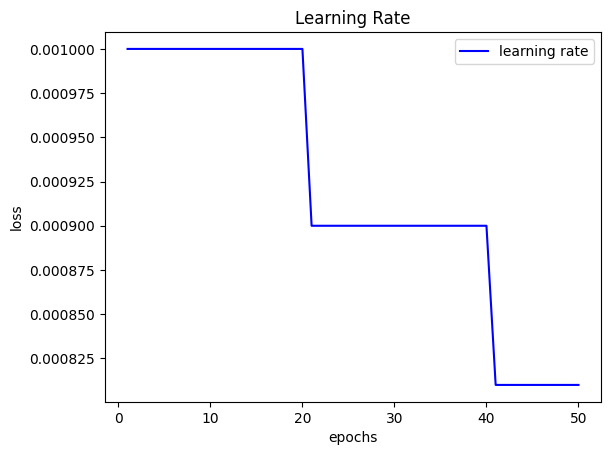

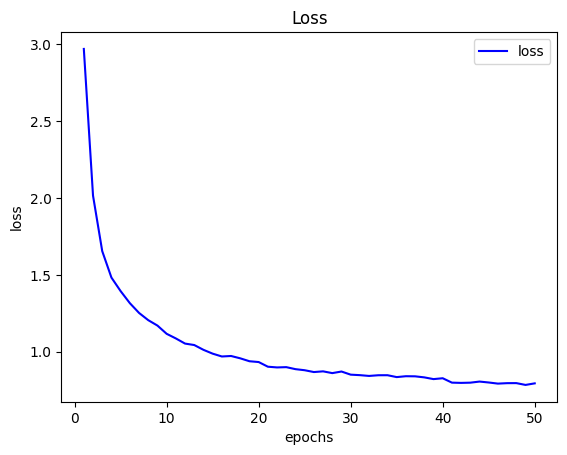

Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.7739
[Epoch: 001] Validation | Loss: 2.3026 | Accuracy: 0.7652
Epoch 1 end
Epoch 2 start
[Epoch: 002] Train      | Loss: 2.3026 | Accuracy: 0.7746
[Epoch: 002] Validation | Loss: 2.3026 | Accuracy: 0.7659
Epoch 2 end
> early stopping counter: 1 out of 30
Epoch 3 start
[Epoch: 003] Train      | Loss: 2.3026 | Accuracy: 0.7745
[Epoch: 003] Validation | Loss: 2.3026 | Accuracy: 0.7665
Epoch 3 end
> early stopping counter: 2 out of 30
Epoch 4 start
[Epoch: 004] Train      | Loss: 2.3026 | Accuracy: 0.7741
[Epoch: 004] Validation | Loss: 2.3026 | Accuracy: 0.7696
Epoch 4 end
> early stopping counter: 3 out of 30
Epoch 5 start
[Epoch: 005] Train      | Loss: 2.3026 | Accuracy: 0.7754
[Epoch: 005] Validation | Loss: 2.3026 | Accuracy: 0.7649
Epoch 5 end
> early stopping counter: 4 out of 30
Epoch 6 start
[Epoch: 006] Train      | Loss: 2.3026 | Accuracy: 0.7740
[Epoch: 006] Validation | Loss: 2.3026 | Accuracy: 0.7684
Epoch 6 

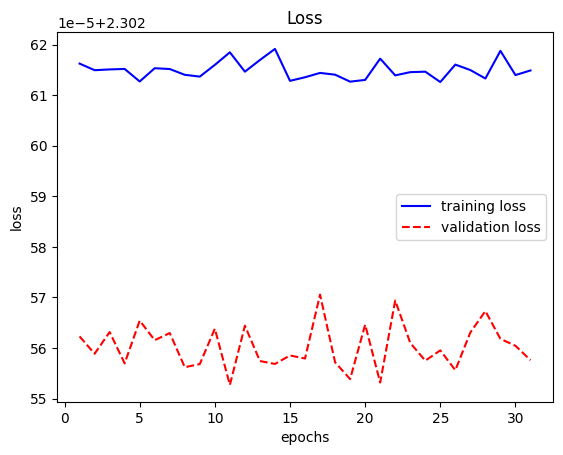

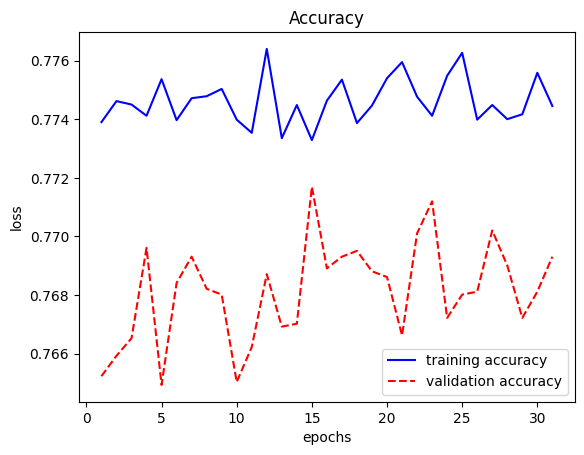

In [ ]:
main()

# Pruning

In [20]:
def perform_pruning(layer = "layer1", prune_prob = 0.9):
    encoder = Encoder()
    head_type = 'mlp'
    num_epochs = 50
    use_early_stopping = True
    use_scheduler = True

    model = SupCon(encoder, head=head_type, feat_dim=128)
    classifier = LinearClassifier()
    criterion = torch.nn.CrossEntropyLoss()

    save_file = os.path.join('./results/', 'model.pth')
    ckpt = torch.load(save_file, map_location='cpu')
    state_dict = ckpt['model']
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    state_dict = new_state_dict
    model.load_state_dict(state_dict)

    for name, param in model.named_parameters():
        print(f"Layer: {name}, Size: {param.size()}")

    print(f"Pruning {layer} with {prune_prob} Prune Probability")

    if layer == "layer1":
      encoder.random_prune_layer1(prune_prob)
    elif layer == "layer2":
      encoder.random_prune_layer2(prune_prob)
    else:
      encoder.random_prune_layer3(prune_prob)

    if torch.cuda.is_available():
        model = model.cuda()
        classifier = classifier.cuda()
        criterion = criterion.cuda()

    train_losses , train_accuracies = [],[]
    valid_losses , valid_accuracies = [],[]

    if use_early_stopping:
        early_stopping = EarlyStopping(patience=30, verbose=False, delta=1e-4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

    for epoch in range(1, num_epochs+1):
        print('Epoch {} start'.format(epoch))

        train_loss, train_accuracy = training(epoch, model, classifier, train_loader, optimizer, criterion)
        valid_loss, valid_accuracy = validation(epoch, model, classifier, valid_loader, criterion)

        if use_scheduler:
            scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print('Epoch {} end'.format(epoch))

        if use_early_stopping:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print('Early stopping at epoch', epoch)
                break

    plt.plot(range(1,len(train_losses)+1), train_losses, color='b', label = 'training loss')
    plt.plot(range(1,len(valid_losses)+1), valid_losses, color='r', linestyle='dashed', label = 'validation loss')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()

    plt.plot(range(1,len(train_accuracies)+1),train_accuracies, color='b', label = 'training accuracy')
    plt.plot(range(1,len(valid_accuracies)+1),valid_accuracies, color='r', linestyle='dashed', label = 'validation accuracy')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Accuracy'), plt.show()

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer1 with 0.9 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.8005
[Epoch: 001

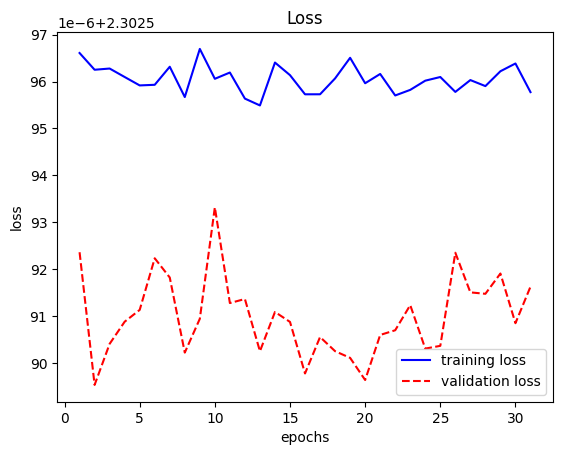

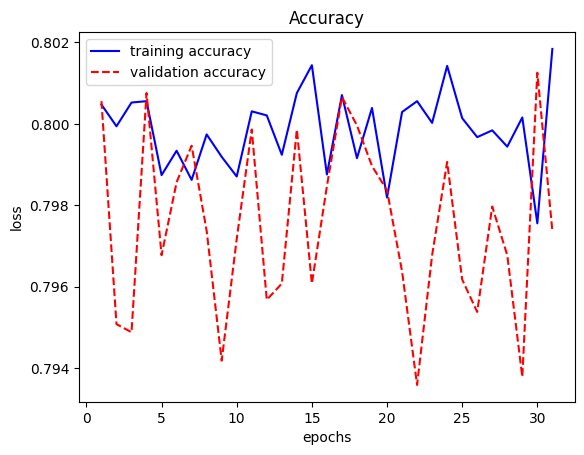

In [ ]:
perform_pruning(layer = "layer1", prune_prob = 0.9)

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer1 with 0.6 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.8436
[Epoch: 001

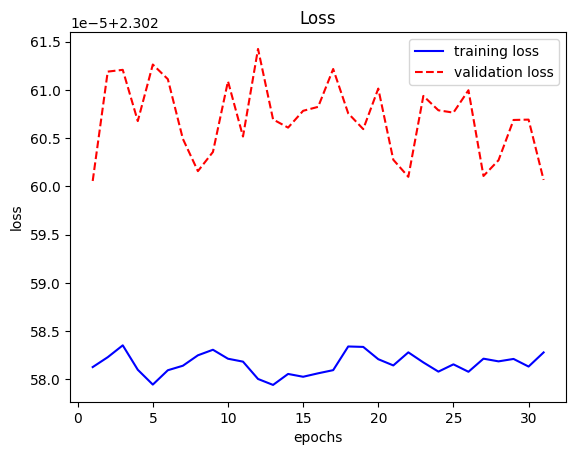

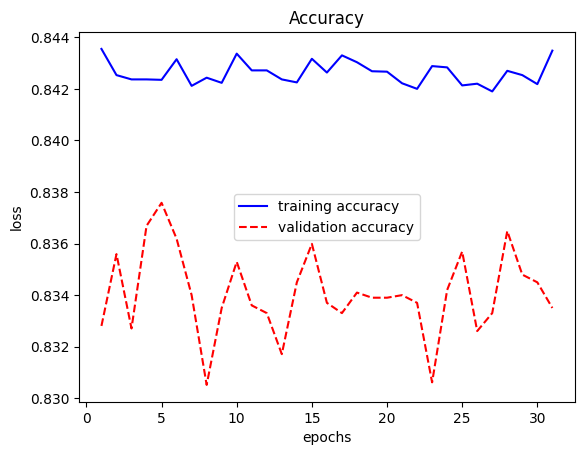

In [ ]:
perform_pruning(layer = "layer1", prune_prob = 0.6)

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer2 with 0.9 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.8098
[Epoch: 001

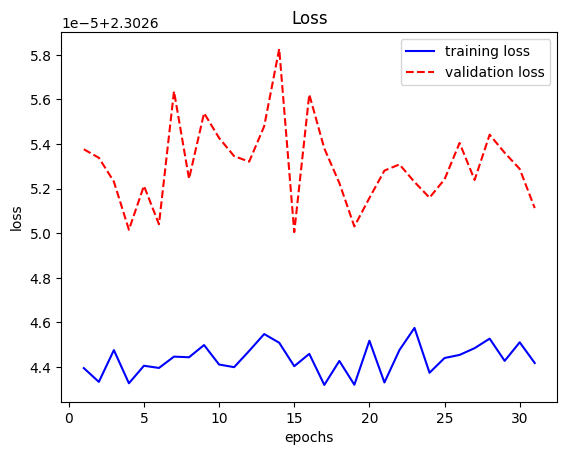

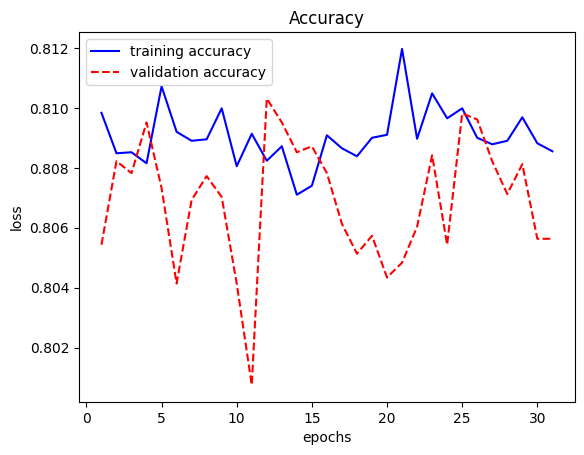

In [21]:
perform_pruning(layer = "layer2", prune_prob = 0.9)

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer2 with 0.6 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.8252
[Epoch: 001

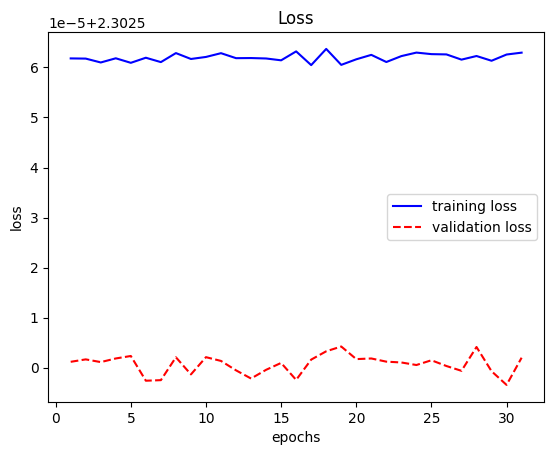

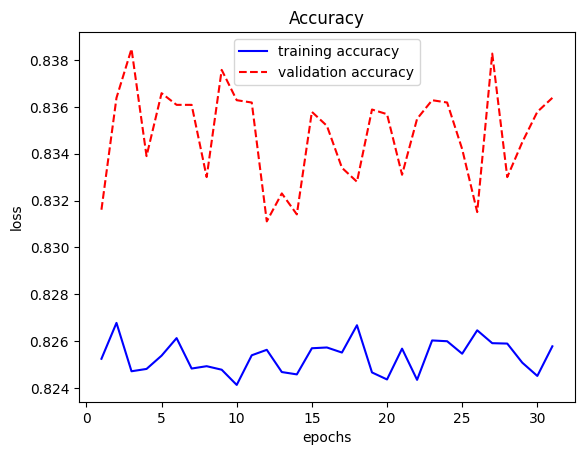

In [22]:
perform_pruning(layer = "layer2", prune_prob = 0.6)

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer3 with 0.9 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3026 | Accuracy: 0.8317
[Epoch: 001

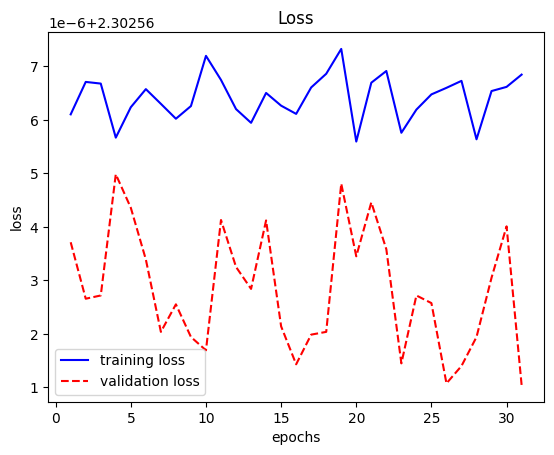

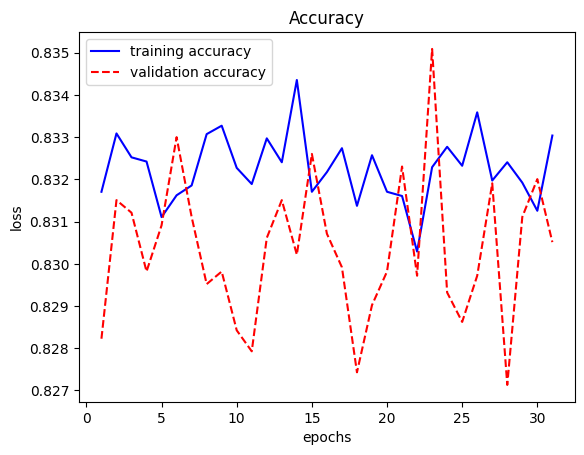

In [23]:
perform_pruning(layer = "layer3", prune_prob = 0.9)

Layer: encoder.layer1.0.weight, Size: torch.Size([32, 3, 3, 3])
Layer: encoder.layer1.0.bias, Size: torch.Size([32])
Layer: encoder.layer1.1.weight, Size: torch.Size([32])
Layer: encoder.layer1.1.bias, Size: torch.Size([32])
Layer: encoder.layer2.0.weight, Size: torch.Size([64, 32, 3, 3])
Layer: encoder.layer2.0.bias, Size: torch.Size([64])
Layer: encoder.layer2.1.weight, Size: torch.Size([64])
Layer: encoder.layer2.1.bias, Size: torch.Size([64])
Layer: encoder.layer3.0.weight, Size: torch.Size([128, 64, 3, 3])
Layer: encoder.layer3.0.bias, Size: torch.Size([128])
Layer: encoder.layer3.1.weight, Size: torch.Size([128])
Layer: encoder.layer3.1.bias, Size: torch.Size([128])
Layer: head.0.weight, Size: torch.Size([2048, 2048])
Layer: head.0.bias, Size: torch.Size([2048])
Layer: head.2.weight, Size: torch.Size([128, 2048])
Layer: head.2.bias, Size: torch.Size([128])
Pruning layer3 with 0.6 Prune Probability
Epoch 1 start
[Epoch: 001] Train      | Loss: 2.3027 | Accuracy: 0.8107
[Epoch: 001

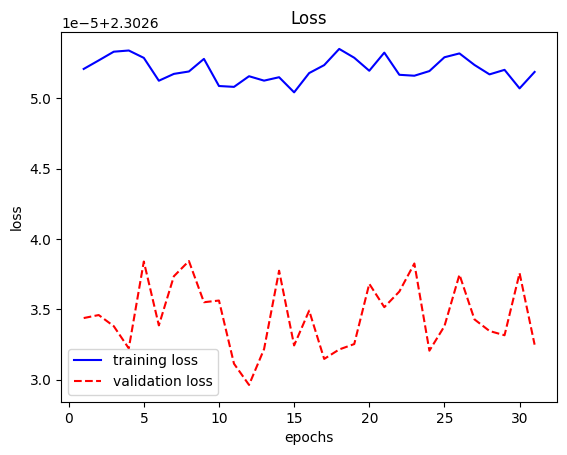

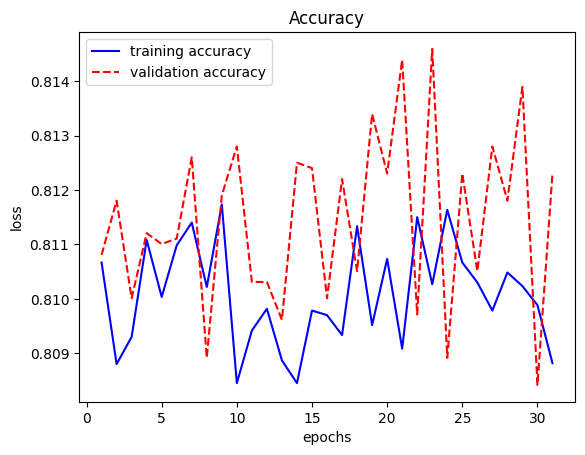

In [24]:
perform_pruning(layer = "layer3", prune_prob = 0.6)